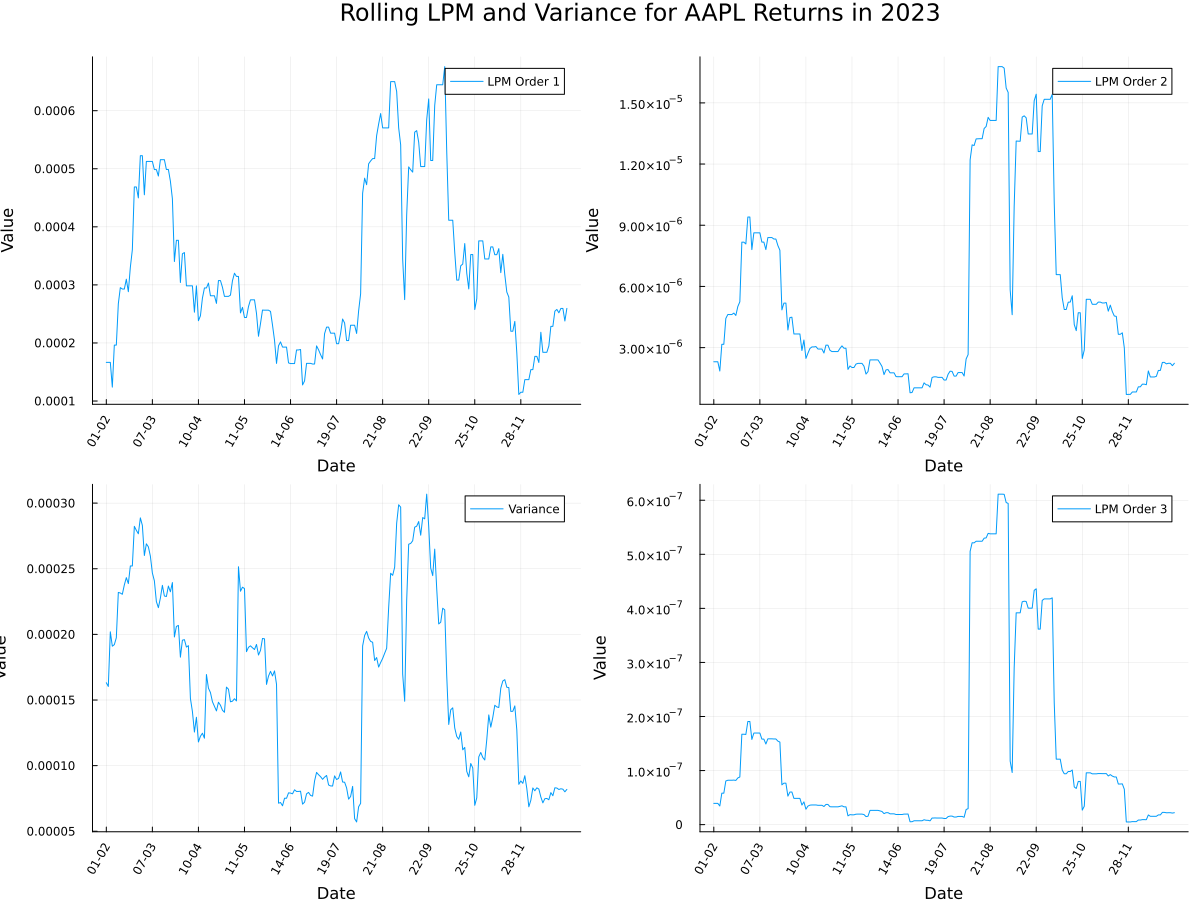

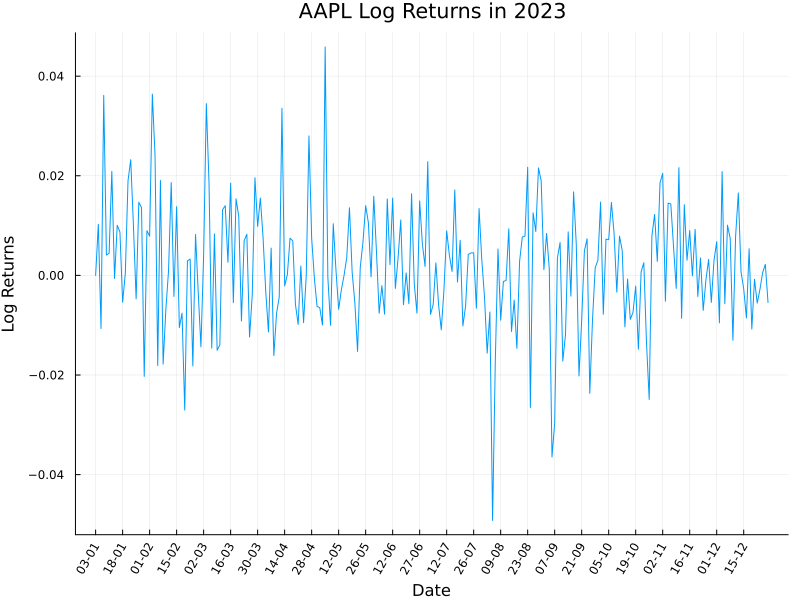

In [3]:
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
using RollingFunctions: rolling, rollvar
using Plots
using Statistics
using Dates
using DataFrames
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
data = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))
series = data.close
data.returns = [0; diff(log.(series))]
returns = data.returns
data.date = [DateTime(x) for x in data.date]
dates = [Dates.format(date, "dd-mm") for date in data.date]

order = 2
function rolling_lpm(series, order, min_returns, window)
    function lpm(s) 
        n = length(series)
        downside(x) = min(min_returns, x)
        return sum((abs.(downside.(s))).^order)/n
    end
    return rolling(lpm, series, window)
end
aapl_lpm2 = rolling_lpm(returns, 2, 0, 20)
aapl_lpm3 = rolling_lpm(returns, 3, 0, 20)
aapl_lpm1 = rolling_lpm(returns, 1, 0, 20)
aapl_lpm05 = rolling_lpm(returns, 0.5, 0, 20)
aapl_lpm4 = rolling_lpm(returns, 4, 0, 20)
aapl_var = rollvar(returns, 20)

labels = ["LPM Order 1" "LPM Order 2" "Variance" "LPM Order 3"]
rolling_dates = dates[21:end]
num = round(Int, length(rolling_dates) / 10)
date_idx = 1:num:length(rolling_dates)

lpms = plot([aapl_lpm1, aapl_lpm2, aapl_var, aapl_lpm3], xticks=(date_idx, rolling_dates[date_idx]), xrot=60, label=labels, layout=4, size=(1200, 900), suptitle="Rolling LPM and Variance for AAPL Returns in 2023", xlabel="Date", ylabel="Value")
savefig(lpms, "lpm_plots/aapl_lpms.svg")

display(lpms)
date_idx = 1:10:length(data.date)
aapl_plot = plot(returns, xticks=(date_idx, dates[date_idx]), xrot=60, title="AAPL Log Returns in 2023", size=(800, 600), xlabel="Date", ylabel="Log Returns", label="")
savefig(aapl_plot, "lpm_plots/aapl_returns.svg")
display(aapl_plot)


# Portfolio LPM

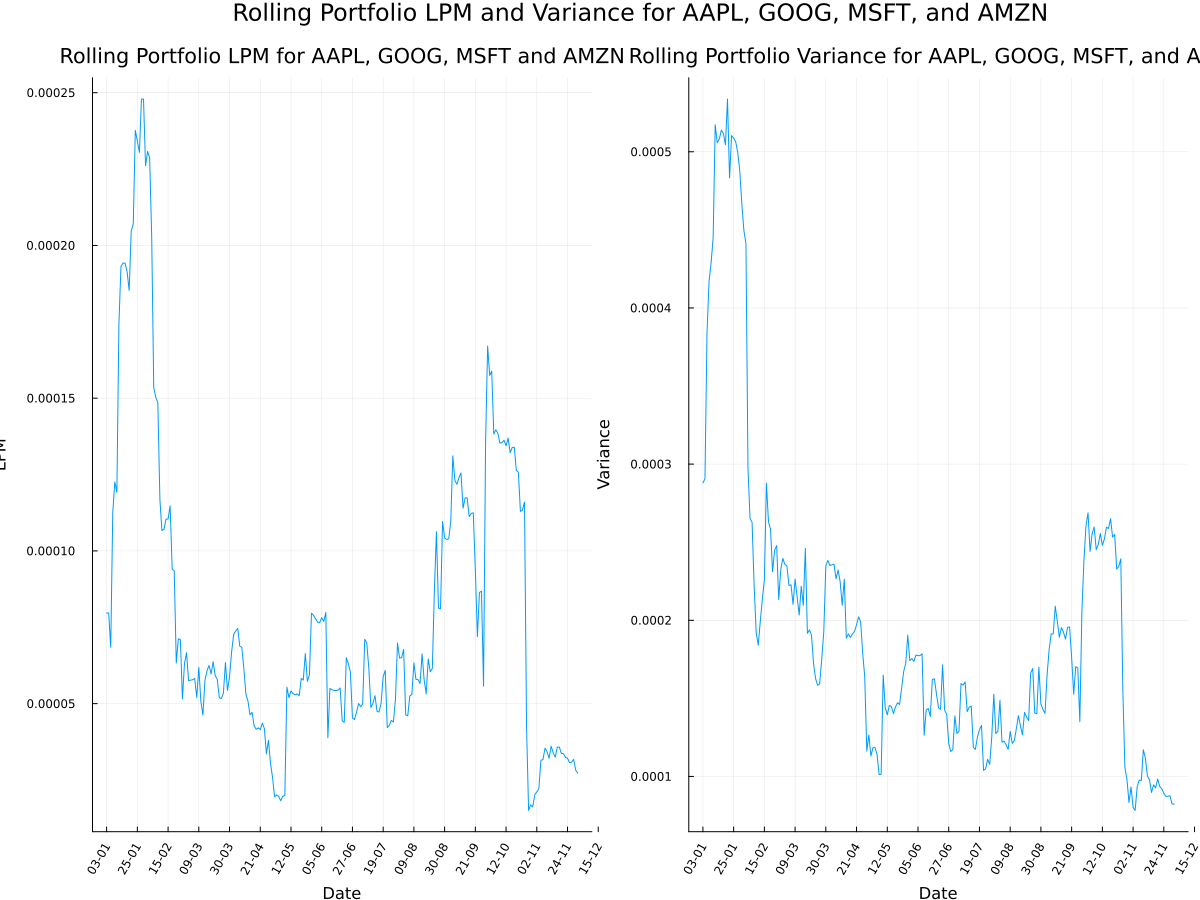

In [94]:
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
using RollingFunctions: rolling, rollvar
using Plots
using Statistics

aapl = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))
goog = get_interday_data(["GOOG"], unix("2023-01-01"), unix("2024-01-01"))
msft = get_interday_data(["MSFT"], unix("2023-01-01"), unix("2024-01-01"))
amzn = get_interday_data(["AMZN"], unix("2023-01-01"), unix("2024-01-01"))

aapl.returns = [0; diff(log.(aapl.close))]
goog.returns = [0; diff(log.(goog.close))]
msft.returns = [0; diff(log.(msft.close))]
amzn.returns = [0; diff(log.(amzn.close))]

dates = [DateTime(x) for x in aapl.date]
dates = [Dates.format(date, "dd-mm") for date in dates]

function semideviation(series, order)
    return (sum(abs.((series[series .< 0])).^order)/length(series))^(1/order)
end

function clpm(s1, s2, order)
    corr = cor(s1, s2)
    return semideviation(s2, order) * semideviation(s1, order) * corr
end

function portfolio_lpm(stocks, weights, order, window)
    n = length(stocks)
    lpm = 0
    for i in 1:n
        for j in 1:n
            lpm += clpm(stocks[i], stocks[j], order) * weights[i] * weights[j]
        end
    end
    return lpm
end

function rolling_portfolio_lpm(s1, s2, s3, s4, weights, order, window)
    function calc_lpm(s1 ,s2, s3, s4)
        return portfolio_lpm([s1, s2, s3, s4], weights, order, window)
    end
    return rolling(calc_lpm, s1, s2, s3, s4, window)
end

weights = [0.25, 0.25, 0.25, 0.25]


function portfolio_var(stocks, weights)
    n = length(stocks)
    var = 0
    for i in 1:n
        for j in 1:n
            var += cov(stocks[i], stocks[j]) * weights[i] * weights[j]
        end
    end
    return var
end

function rolling_portfolio_var(s1, s2, s3, s4, weights, window)
    function calc_var(s1 ,s2, s3, s4)
        return portfolio_var([s1, s2, s3, s4], weights)
    end
    return rolling(calc_var, s1, s2, s3, s4, window)
end

portfolio_var_vals = rolling_portfolio_var(aapl.returns, goog.returns, msft.returns, amzn.returns, weights, 20)

rolling_var_plot = plot(portfolio_var_vals, xticks=(1:15:length(dates), dates[1:15:end]), xrot=60, title="Rolling Portfolio Variance for AAPL, GOOG, MSFT, and AMZN", size=(800, 600), xlabel="Date", ylabel="Variance", label="")
lpm_vals = rolling_portfolio_lpm(aapl.returns, goog.returns, msft.returns, amzn.returns, weights, 2, 20)

rolling_lpm_plot = plot(lpm_vals, xticks=(1:15:length(dates), dates[1:15:end]), xrot=60, title="Rolling Portfolio LPM for AAPL, GOOG, MSFT and AMZN", size=(800, 600), xlabel="Date", ylabel="LPM", label="")
rolling_var_plot = plot(portfolio_var_vals, xticks=(1:15:length(dates), dates[1:15:end]), xrot=60, title="Rolling Portfolio Variance for AAPL, GOOG, MSFT, and AMZN", size=(800, 600), xlabel="Date", ylabel="Variance", label="")

plot(rolling_lpm_plot, rolling_var_plot, layout=2, size=(1200, 900), suptitle="Rolling Portfolio LPM and Variance for AAPL, GOOG, MSFT, and AMZN", xlabel="Date")

